In [1]:
import pandas as pd
import polars as pl
import plotnine as pn
import numpy as np
from tqdm.notebook import tqdm

import lightgbm as lgb
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer,
)
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, root_mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import config_context
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate
import os
import holidays

%load_ext blackcellmagic

### Data Preparation

Focus on CH spot price first

In [2]:
df = pd.read_csv(
    "../../00 Data Retrieval and Cleaning/0_df_final_ml_predictive.csv",
    parse_dates=["date"],
)
df.head()

,date,auction_price_ch_de,auction_price_de_ch,dst,day_ahead_price_at,day_ahead_price_ch,day_ahead_price_de,day_ahead_price_fr,day_ahead_price_it,actual_load_at,...,wind_offshore_actual_aggregated_it,wind_offshore_forecast_de,wind_onshore_actual_aggregated_at,wind_onshore_actual_aggregated_de,wind_onshore_actual_aggregated_fr,wind_onshore_actual_aggregated_it,wind_onshore_ch,wind_onshore_forecast_at,wind_onshore_forecast_de,wind_onshore_forecast_fr
0,2023-01-01 00:00:00+00:00,0.01,6.09,1,NaN,-7.25,-1.07,NaN,NaN,NaN,...,NaN,3390.25,NaN,NaN,NaN,NaN,NaN,1174.0,35415.50,13933.0
1,2023-01-01 01:00:00+00:00,0.01,5.50,1,NaN,-3.99,-1.47,NaN,NaN,NaN,...,NaN,3395.50,NaN,NaN,NaN,NaN,NaN,1194.0,35146.75,13583.0
2,2023-01-01 02:00:00+00:00,0.01,6.45,1,NaN,-7.71,-5.08,NaN,NaN,NaN,...,NaN,3410.25,NaN,NaN,NaN,NaN,NaN,1085.0,34449.00,13230.0
3,2023-01-01 03:00:00+00:00,0.01,9.08,1,NaN,-9.71,-4.49,NaN,NaN,NaN,...,NaN,3431.25,NaN,NaN,NaN,NaN,NaN,897.0,33905.25,12877.0
4,2023-01-01 04:00:00+00:00,0.01,13.33,1,NaN,-15.15,-5.40,NaN,NaN,NaN,...,NaN,3454.25,NaN,NaN,NaN,NaN,NaN,697.0,33362.75,12311.0


Need to lag the other three target variables by 24 hours, haven't done that yet:

In [3]:
df = (
    df
    .assign(
        day_ahead_price_de=lambda x: x["day_ahead_price_de"].shift(24),
        auction_price_de_ch=lambda x: x["auction_price_de_ch"].shift(24),
        auction_price_ch_de=lambda x: x["auction_price_ch_de"].shift(24),
    )
)

### Include target lags

- latest available price (last price of previous day)
- last two week prices at exact hour (14 additional cols)

In [4]:
# Adding last available price from previous day
df = df.assign(
    day=lambda x: x.date.dt.date,
    day_ahead_price_ch_last=lambda x: x.groupby("day")["day_ahead_price_ch"].transform("last").shift(24),
)

In [5]:
# Adding lags in 24h steps for the last two weeks
for i in range(1, 15):
    h = i * 24
    df[f"day_ahead_price_ch_lag_{h}"] = df["day_ahead_price_ch"].shift(h)

In [6]:
df.filter(regex="day_ahead_price_ch").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9501 entries, 0 to 9500
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   day_ahead_price_ch          9501 non-null   float64
 1   day_ahead_price_ch_last     9477 non-null   float64
 2   day_ahead_price_ch_lag_24   9477 non-null   float64
 3   day_ahead_price_ch_lag_48   9453 non-null   float64
 4   day_ahead_price_ch_lag_72   9429 non-null   float64
 5   day_ahead_price_ch_lag_96   9405 non-null   float64
 6   day_ahead_price_ch_lag_120  9381 non-null   float64
 7   day_ahead_price_ch_lag_144  9357 non-null   float64
 8   day_ahead_price_ch_lag_168  9333 non-null   float64
 9   day_ahead_price_ch_lag_192  9309 non-null   float64
 10  day_ahead_price_ch_lag_216  9285 non-null   float64
 11  day_ahead_price_ch_lag_240  9261 non-null   float64
 12  day_ahead_price_ch_lag_264  9237 non-null   float64
 13  day_ahead_price_ch_lag_288  9213 

### Additional Feature Generation

- There might be a benefit of encoding cyclical calendar information
- Additionally: Holidays

Include a trend column:

In [7]:
df = df.assign(trend=lambda x: x.index)

In [8]:
# Define the country (Switzerland)
country = "CH"

regional_holidays = holidays.CH(
    years=df.date.dt.year.unique().tolist()
)

In [9]:
holiday_df = pd.DataFrame(
    {
        "holiday_name": list(regional_holidays.values()),
        "holiday_date": list(regional_holidays.keys()),
    }
)

holiday_df.sort_values("holiday_date").head()

,holiday_name,holiday_date
4,Neujahrestag,2023-01-01
5,Auffahrt,2023-05-18
6,Nationalfeiertag,2023-08-01
7,Weihnachten,2023-12-25
0,Neujahrestag,2024-01-01


In [10]:
holiday_df.value_counts("holiday_name")

holiday_name
Auffahrt            2
Nationalfeiertag    2
Neujahrestag        2
Weihnachten         2
Name: count, dtype: int64

In [11]:
df = (
    df.assign(
        hour=lambda x: x.date.dt.hour + 1,
        month=lambda x: x.date.dt.month,
        quarter=lambda x: x.date.dt.quarter,
        wday=lambda x: x.date.dt.day_of_week + 1,
        weekend=lambda x: np.where(
            x.date.dt.day_name().isin(["Sunday", "Saturday"]), 1, 0
        ),
        work_hour=lambda x: np.where(
            x["hour"].isin(np.arange(17, 24).tolist() + np.arange(1, 5).tolist()), 0, 1
        ),
        week_hour=lambda x: x.date.dt.dayofweek * 24 + (x.date.dt.hour + 1),
        year=lambda x: x.date.dt.year,
        hour_counter=lambda x: np.arange(0, x.shape[0]),
    )
    .assign(day=lambda x: x.date.dt.date)
    .merge(holiday_df, how="left", left_on="day", right_on="holiday_date")
    .drop(["holiday_date", "day"], axis=1)
    .assign(
        holiday_name=lambda x: np.where(
            x["holiday_name"].isna(), "none", x["holiday_name"]
        )
    )
)

In [12]:
df.value_counts("holiday_name")

holiday_name
none                9381
Neujahrestag          48
Auffahrt              24
Nationalfeiertag      24
Weihnachten           24
Name: count, dtype: int64

### Feature Engineering

Other:
- `date`: drop, can't feed into net

Numerical:
- everything but `holiday_name`

Categorical
- `holiday_name`: one-hot encode

#### Cyclical Encoding

- avoid issue with exploding feature space when one-hot encoding hundreds of levels in categorical vars
- puts end of cycle closer to beginning (End of Year is not that different from BOY)

In [13]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [14]:
# hour in day
df["hour_sin"] = sin_transformer(24).fit_transform(df["hour"].astype(float))
df["hour_cos"] = cos_transformer(24).fit_transform(df["hour"].astype(float))

# hour in week
df["week_hour_sin"] = sin_transformer(168).fit_transform(df["week_hour"].astype(float))
df["week_hour_cos"] = cos_transformer(168).fit_transform(df["week_hour"].astype(float))

# month
df["month_sin"] = sin_transformer(12).fit_transform(df["month"].astype(float))
df["month_cos"] = cos_transformer(12).fit_transform(df["month"].astype(float))

# quarter
df["quarter_sin"] = sin_transformer(4).fit_transform(df["quarter"].astype(float))
df["quarter_cos"] = cos_transformer(4).fit_transform(df["quarter"].astype(float))

# weekday
df["wday_sin"] = sin_transformer(7).fit_transform(df["wday"].astype(float))
df["wday_cos"] = cos_transformer(7).fit_transform(df["wday"].astype(float))

df = df.drop(["hour", "month", "quarter", "wday", "week_hour"], axis=1)

#### `sklearn` Pipeline for Data Preparation

In [15]:
manual_cols = ["trend", "unique_id"]
drop_cols = ["date", "day_ahead_price_ch"]

pipeline_cols = [
    col
    for col in df.drop(drop_cols, axis=1).columns
    if col not in manual_cols
]

num_cols = (
    df.drop(drop_cols, axis=1)
    .filter(pipeline_cols)
    .select_dtypes(include=np.number)
    .columns
)
cat_cols = (
    df.drop(drop_cols, axis=1)
    .filter(pipeline_cols)
    .select_dtypes(exclude=np.number)
    .columns
)

In [16]:
pipeline_cols

['auction_price_ch_de',
 'auction_price_de_ch',
 'dst',
 'day_ahead_price_at',
 'day_ahead_price_de',
 'day_ahead_price_fr',
 'day_ahead_price_it',
 'actual_load_at',
 'actual_load_ch',
 'actual_load_de',
 'actual_load_fr',
 'actual_load_it',
 'allocated_capacity_ch_de',
 'allocated_capacity_de_ch',
 'biomass_actual_aggregated_at',
 'biomass_actual_aggregated_de',
 'biomass_actual_aggregated_fr',
 'biomass_actual_aggregated_it',
 'capacity_forecast_at_ch',
 'capacity_forecast_ch_at',
 'capacity_forecast_ch_de_lu',
 'capacity_forecast_ch_fr',
 'capacity_forecast_ch_it',
 'capacity_forecast_de_lu_ch',
 'capacity_forecast_fr_ch',
 'capacity_forecast_it_ch',
 'crossborder_actual_flow_at_ch',
 'crossborder_actual_flow_ch_at',
 'crossborder_actual_flow_ch_de_lu',
 'crossborder_actual_flow_ch_fr',
 'crossborder_actual_flow_ch_it',
 'crossborder_actual_flow_de_lu_ch',
 'crossborder_actual_flow_fr_ch',
 'crossborder_actual_flow_it_ch',
 'fossil_brown_coal_lignite_actual_aggregated_de',
 'fossil

In [17]:
num_cols

Index(['auction_price_ch_de', 'auction_price_de_ch', 'dst',
       'day_ahead_price_at', 'day_ahead_price_de', 'day_ahead_price_fr',
       'day_ahead_price_it', 'actual_load_at', 'actual_load_ch',
       'actual_load_de',
       ...
       'hour_sin', 'hour_cos', 'week_hour_sin', 'week_hour_cos', 'month_sin',
       'month_cos', 'quarter_sin', 'quarter_cos', 'wday_sin', 'wday_cos'],
      dtype='object', length=131)

In [18]:
cat_cols

Index(['holiday_name'], dtype='object')

In [19]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer()),
        # ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "encoder",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        ),
    ]
)

# Making column transformer where all transformers in the pipelines are included
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, num_cols),
        ("categorical", categorical_transformer, cat_cols),
    ],
    remainder="passthrough",
)

### Split and preprocess the data

In [20]:
train_end = pd.Timestamp("2023-09-01").tz_localize("UTC")
val_end = pd.Timestamp("2024-01-01").tz_localize("UTC")

# Create splits
df_train = df.query("date < @val_end").reset_index(drop=True)
# df_val = df.query("date < @val_end").query("date >= @train_end")
df_test = df.query("date >= @val_end")

In [21]:
X_train = df_train.drop(columns=["date", "day_ahead_price_ch"])
y_train = df_train["day_ahead_price_ch"]

# X_val = df_val.drop(columns=["date", "day_ahead_price_ch"])
# y_val = df_val["day_ahead_price_ch"]

X_test = df_test.drop(columns=["date", "day_ahead_price_ch"])
y_test = df_test["day_ahead_price_ch"]

In [22]:
fitted_preprocessor = preprocessor.fit(X_train)

In [23]:
X_train_preprocessed = pd.DataFrame(
    fitted_preprocessor.transform(X_train),
    columns=fitted_preprocessor.get_feature_names_out(),
)

# X_val_preprocessed = pd.DataFrame(
#     fitted_preprocessor.transform(X_val),
#     columns=fitted_preprocessor.get_feature_names_out(),
# )

X_test_preprocessed = pd.DataFrame(
    fitted_preprocessor.transform(X_test),
    columns=fitted_preprocessor.get_feature_names_out(),
)

In [24]:
# Replace prefixes in column names
new_cols = X_train_preprocessed.columns.str.replace('numeric__', '').str.replace('categorical__', '').str.replace('remainder__', '')

# Assign new column names to the DataFrame
X_train_preprocessed.columns = new_cols
# X_val_preprocessed.columns = new_cols
X_test_preprocessed.columns = new_cols

In [25]:
X_train_preprocessed.tail()

,auction_price_ch_de,auction_price_de_ch,dst,day_ahead_price_at,day_ahead_price_de,day_ahead_price_fr,day_ahead_price_it,actual_load_at,actual_load_ch,actual_load_de,...,quarter_sin,quarter_cos,wday_sin,wday_cos,holiday_name_Auffahrt,holiday_name_Nationalfeiertag,holiday_name_Neujahrestag,holiday_name_Weihnachten,holiday_name_none,trend
8753,0.21,0.92,1.0,62.01,62.01,62.01,125.35,6354.25,6933.0,48621.75,...,-2.449294e-16,1.0,-2.449294e-16,1.0,0.0,0.0,0.0,0.0,1.0,8753.0
8754,0.08,0.92,1.0,53.11,56.36,28.73,113.29,5978.25,6645.0,46089.50,...,-2.449294e-16,1.0,-2.449294e-16,1.0,0.0,0.0,0.0,0.0,1.0,8754.0
8755,0.03,1.11,1.0,50.10,50.10,50.10,110.00,5947.00,6408.0,44277.25,...,-2.449294e-16,1.0,-2.449294e-16,1.0,0.0,0.0,0.0,0.0,1.0,8755.0
8756,0.01,0.54,1.0,43.23,43.23,43.23,108.62,5597.50,6364.0,41249.00,...,-2.449294e-16,1.0,-2.449294e-16,1.0,0.0,0.0,0.0,0.0,1.0,8756.0
8757,0.00,2.51,1.0,34.32,36.54,18.21,109.12,5399.75,6500.0,38988.00,...,-2.449294e-16,1.0,-2.449294e-16,1.0,0.0,0.0,0.0,0.0,1.0,8757.0


### Cross Validation Splits

In [26]:
tscv = TimeSeriesSplit(n_splits=5)

X_train_splits_train = []
y_train_splits_train = []

X_train_splits_val = []
y_train_splits_val = []

# Create the splits
for split_idx, (train_index, test_index) in enumerate(tscv.split(X_train_preprocessed)):
    
    # Get the training and testing data
    X_train_splits_train.append(X_train_preprocessed.iloc[train_index])
    y_train_splits_train.append(y_train.iloc[train_index])

    X_train_splits_val.append(X_train_preprocessed.iloc[test_index])
    y_train_splits_val.append(y_train.iloc[test_index])

### Use LASSO to preselect variables

In [27]:
alphas = np.linspace(0.3, 0.8, 25)
cv_scores_is = []
cv_scores_oos = []
scaler = StandardScaler()

for alpha in tqdm(alphas):

    cv_losses_is = []
    cv_losses_oos = []

    for X_train_cv, y_train_cv, X_val_cv, y_val_cv in zip(
        X_train_splits_train, y_train_splits_train, X_train_splits_val, y_train_splits_val
    ):

        # Scale data
        fitted_scaler = scaler.fit(X_train_cv)
        
        X_train_cv = fitted_scaler.transform(X_train_cv)
        X_val_cv = fitted_scaler.transform(X_val_cv)

        # Train the model
        model = Lasso(alpha=alpha).fit(X_train_cv, y_train_cv)

        # Calculate in sample loss
        is_loss = root_mean_squared_error(y_train_cv, model.predict(X_train_cv))
        cv_losses_is.append(is_loss)

        # Calculate out of sample loss
        oos_loss = root_mean_squared_error(y_val_cv, model.predict(X_val_cv))
        cv_losses_oos.append(oos_loss)

    # Calculate the mean loss
    cv_scores_is.append(np.mean(cv_losses_is))
    cv_scores_oos.append(np.mean(cv_losses_oos))
    

  0%|          | 0/25 [00:00<?, ?it/s]

<Axes: xlabel='alpha'>

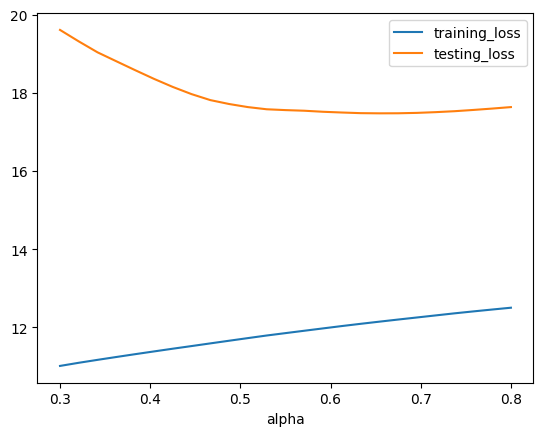

In [28]:
pd.DataFrame({"alpha": alphas, "training_loss": cv_scores_is, "testing_loss": cv_scores_oos}).plot(x="alpha", y=["training_loss", "testing_loss"])

Identify the best alpha, fit the Lasso and select the variables that remain:

In [29]:
best_lasso = Lasso(alpha=0.8, max_iter=5000).fit(X_train_preprocessed, y_train)

<Axes: title={'center': 'In Sample'}>

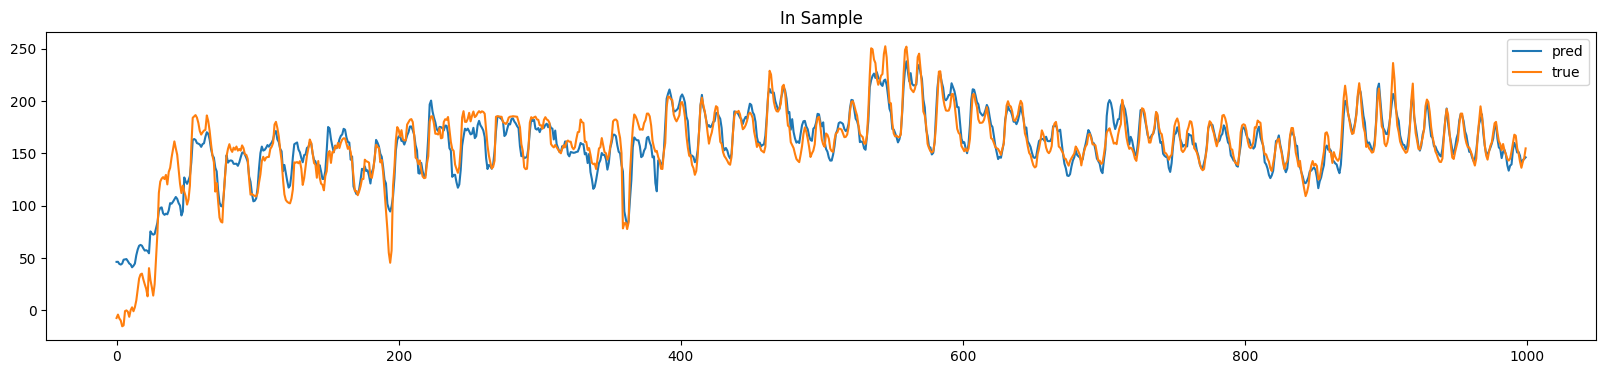

In [33]:
pd.DataFrame({
    "pred": best_lasso.predict(X_train_preprocessed),
    "true": y_train
}).head(1000).plot(figsize=(20, 4), title="In Sample")

<Axes: title={'center': 'Out of sample'}>

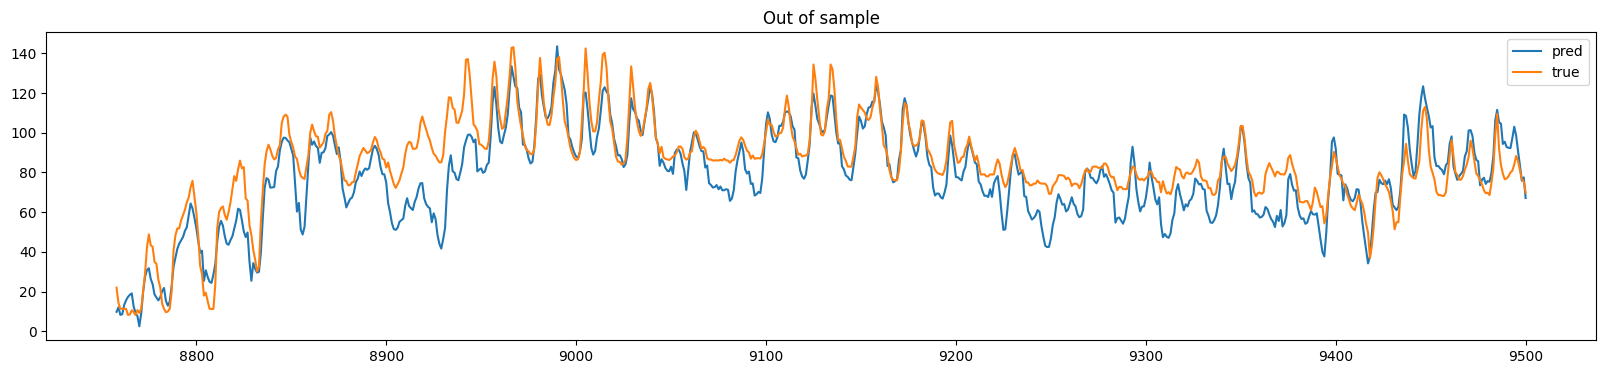

In [34]:
preds = pd.DataFrame({
    "pred": best_lasso.predict(X_test_preprocessed),
    "true": y_test
})

preds.plot(figsize=(20, 4), title="Out of sample")

In [32]:
feature_df = pd.DataFrame({
    "coef": best_lasso.coef_,
    "feature": X_train_preprocessed.columns
}).query("abs(coef) > 1e-6")

feature_df

,coef,feature
0,-0.129556,auction_price_ch_de
1,0.054553,auction_price_de_ch
3,0.056416,day_ahead_price_at
5,0.072036,day_ahead_price_fr
6,0.117862,day_ahead_price_it
...,...,...
113,-0.025106,day_ahead_price_ch_lag_264
114,-0.047471,day_ahead_price_ch_lag_288
115,0.075354,day_ahead_price_ch_lag_312
116,0.084499,day_ahead_price_ch_lag_336


In [38]:
print("Metric for LASSO Model")
print("R2 Score: ", r2_score(preds["true"], preds["pred"]))
print("MAE: ", mean_absolute_error(preds["true"], preds["pred"]))
print("MAPE: ", mean_absolute_percentage_error(preds["true"], preds["pred"]))
print("RMSE: ", root_mean_squared_error(preds["true"], preds["pred"]))

Metric for LASSO Model
R2 Score:  0.6812721468023979
MAE:  10.164513027002041
MAPE:  0.14173925803403184
RMSE:  13.070907317238904


In [90]:
X_train_preprocessed = X_train_preprocessed.filter(feature_df.feature.sort_values())
X_test_preprocessed = X_test_preprocessed.filter(feature_df.feature.sort_values())

### Tune hyperparameters

Use cross validation on training set for hyperparameter tuning

In [91]:
# Function to define and optimize LightGBM hyperparameters
def objective(trial):
    
    # Define the parameter grid
    param = {
        "verbose": -1,
        'objective': 'regression', 
        'metric': 'rmse',
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        "max_depth" : trial.suggest_int('max_depth', 3, 15),
        'num_leaves': trial.suggest_int('num_leaves', 10, 120),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 1e-8, 1.0, log=True),
    }

    cv_losses = []

    for X_train_cv, y_train_cv, X_val_cv, y_val_cv in zip(
        X_train_splits_train, y_train_splits_train, X_train_splits_val, y_train_splits_val
    ):

        # Create LightGBM dataset
        train_data = lgb.Dataset(X_train_cv, label=y_train_cv, free_raw_data=False)
        valid_data = lgb.Dataset(X_val_cv, label=y_val_cv, free_raw_data=False)

        # Train the model
        bst = lgb.train(
            params=param,
            train_set=train_data,
            valid_sets=[valid_data],
            num_boost_round=1000,
            callbacks=[lgb.early_stopping(stopping_rounds=10)],
        )

        # Make predictions on validation set
        y_pred = bst.predict(X_val_cv, num_iteration=bst.best_iteration)

        # Calculate loss
        loss = root_mean_squared_error(y_val_cv, y_pred)
        cv_losses.append(loss)

    # Calculate the mean loss
    mean_cv_loss = np.mean(cv_losses)

    return mean_cv_loss

In [92]:
# Create a study object and specify the direction (minimize)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=None, timeout=60*2)

[I 2024-05-19 23:11:16,950] A new study created in memory with name: no-name-1c650240-09a7-48ad-97ca-610df0b24b51


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[95]	valid_0's rmse: 25.5411
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[110]	valid_0's rmse: 19.1858
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 15.2824
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[98]	valid_0's rmse: 14.6974
Training until validation scores don't improve for 10 rounds


[I 2024-05-19 23:11:19,446] Trial 0 finished with value: 18.05824723307404 and parameters: {'learning_rate': 0.05909841541846396, 'max_depth': 11, 'num_leaves': 21, 'lambda_l1': 9.738139247665856e-08, 'lambda_l2': 0.00045346106609494733, 'min_split_gain': 5.381558441594802e-07}. Best is trial 0 with value: 18.05824723307404.


Early stopping, best iteration is:
[227]	valid_0's rmse: 15.5845
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[152]	valid_0's rmse: 24.5327
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[187]	valid_0's rmse: 20.1515
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 15.945
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[150]	valid_0's rmse: 15.4165
Training until validation scores don't improve for 10 rounds


[I 2024-05-19 23:11:23,067] Trial 1 finished with value: 18.522318568447567 and parameters: {'learning_rate': 0.046722994184293334, 'max_depth': 7, 'num_leaves': 96, 'lambda_l1': 2.655215984872778e-08, 'lambda_l2': 1.5065497140862253e-08, 'min_split_gain': 0.012008452423211054}. Best is trial 0 with value: 18.05824723307404.


Early stopping, best iteration is:
[244]	valid_0's rmse: 16.566
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 42.3674
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 48.5519
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 32.0574
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 26.835
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 36.1608


[I 2024-05-19 23:12:18,584] Trial 2 finished with value: 37.19450406675442 and parameters: {'learning_rate': 0.0003046450918445348, 'max_depth': 13, 'num_leaves': 71, 'lambda_l1': 1.3179555408224377e-06, 'lambda_l2': 2.196694801454505e-05, 'min_split_gain': 0.0061457214576024115}. Best is trial 0 with value: 18.05824723307404.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[184]	valid_0's rmse: 25.6109
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[264]	valid_0's rmse: 19.403
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	valid_0's rmse: 15.8195
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[197]	valid_0's rmse: 15.1081
Training until validation scores don't improve for 10 rounds


[I 2024-05-19 23:12:24,342] Trial 3 finished with value: 18.47685801474963 and parameters: {'learning_rate': 0.04244351691636236, 'max_depth': 14, 'num_leaves': 46, 'lambda_l1': 0.050909393528639685, 'lambda_l2': 6.016148485482161e-05, 'min_split_gain': 0.00013277755023773224}. Best is trial 0 with value: 18.05824723307404.


Early stopping, best iteration is:
[217]	valid_0's rmse: 16.4428
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 28.084
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 25.6799
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[818]	valid_0's rmse: 16.3075
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 16.6222
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 19.6986


[I 2024-05-19 23:13:14,521] Trial 4 finished with value: 21.278438329473143 and parameters: {'learning_rate': 0.0019175581577910079, 'max_depth': 8, 'num_leaves': 105, 'lambda_l1': 0.273646680391711, 'lambda_l2': 0.009570703847551768, 'min_split_gain': 0.0002090418779502901}. Best is trial 0 with value: 18.05824723307404.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[314]	valid_0's rmse: 25.226
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[247]	valid_0's rmse: 19.4201
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[57]	valid_0's rmse: 15.4164
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[183]	valid_0's rmse: 14.9856
Training until validation scores don't improve for 10 rounds


[I 2024-05-19 23:13:25,389] Trial 5 finished with value: 18.18809215770498 and parameters: {'learning_rate': 0.02862082912592219, 'max_depth': 11, 'num_leaves': 39, 'lambda_l1': 2.1560505915846957e-07, 'lambda_l2': 0.02404340167439314, 'min_split_gain': 5.35833974816507e-07}. Best is trial 0 with value: 18.05824723307404.


Early stopping, best iteration is:
[558]	valid_0's rmse: 15.8924


In [93]:
# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)
print("Best RMSE: ", study.best_value)

Best hyperparameters:  {'learning_rate': 0.05909841541846396, 'max_depth': 11, 'num_leaves': 21, 'lambda_l1': 9.738139247665856e-08, 'lambda_l2': 0.00045346106609494733, 'min_split_gain': 5.381558441594802e-07}
Best RMSE:  18.05824723307404


In [97]:
plot_optimization_history(study)

In [98]:
plot_parallel_coordinate(study)

In [99]:
plot_param_importances(study)

### Train the best model on entire dataset

In [100]:
study.best_params

{'learning_rate': 0.05909841541846396,
 'max_depth': 11,
 'num_leaves': 21,
 'lambda_l1': 9.738139247665856e-08,
 'lambda_l2': 0.00045346106609494733,
 'min_split_gain': 5.381558441594802e-07}

In [101]:
study.best_value

18.05824723307404

In [102]:
# Use only two weeks for the validation set in the final model
val_end_final = pd.Timestamp("2023-12-15").tz_localize("UTC")

X_train_preprocessed_final = X_train_preprocessed.iloc[df_train.query("date < @val_end_final").index]
X_val_preprocessed_final = X_train_preprocessed.iloc[df_train.query("date >= @val_end_final").index]

y_train_final = y_train.iloc[df_train.query("date < @val_end_final").index]
y_val_final = y_train.iloc[df_train.query("date >= @val_end_final").index] 

In [103]:
# Create LightGBM dataset
train_data = lgb.Dataset(X_train_preprocessed_final, label=y_train_final, free_raw_data=False)
valid_data = lgb.Dataset(X_val_preprocessed_final, label=y_val_final, free_raw_data=False)

# Train the model
bst = lgb.train(
    params=study.best_params,
    train_set=train_data,
    valid_sets=[valid_data],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=10)],
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25652
[LightGBM] [Info] Number of data points in the train set: 8350, number of used features: 111
[LightGBM] [Info] Start training from score 110.100814
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[69]	valid_0's l2: 146.151


In [104]:
# Make predictions on validation set
y_pred = bst.predict(X_test_preprocessed, num_iteration=bst.best_iteration)

# Calculate loss
loss = root_mean_squared_error(y_test, y_pred)

loss

15.329910214763533

<Axes: >

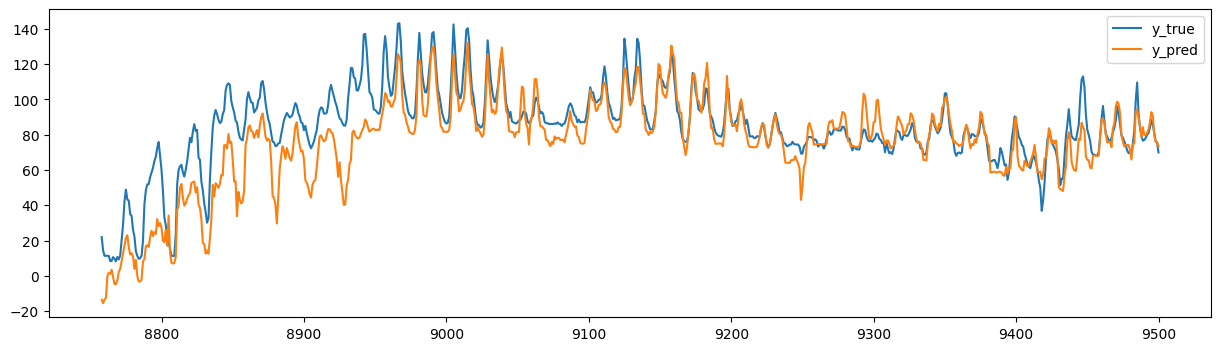

In [107]:
pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred
}).plot(figsize=(15, 4))

<Axes: >

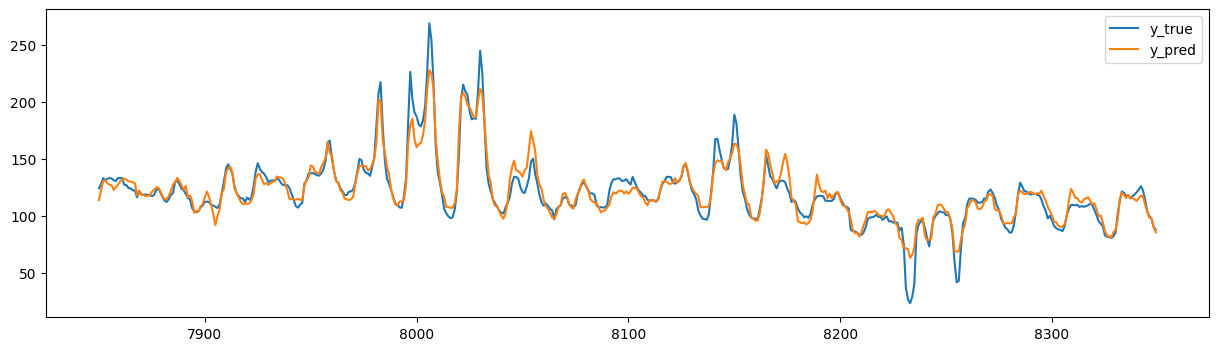

In [110]:
pd.DataFrame({
    "y_true": y_train_final,
    "y_pred": bst.predict(X_train_preprocessed_final)
}).tail(500).plot(figsize=(15, 4))

In [ ]:
# Save the model
bst.save_model("model.txt", num_iteration=bst.best_iteration)